In [1]:
from functools import partial
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy.sparse
import torch
import torch.nn as nn
from swing_solver import solve

from graph import get_ba, get_er, get_rr, get_shk, get_ws
from graph.utils import get_edge_list, get_weighted_adjacency_matrix

In [3]:
device = torch.device("cuda")
precision = np.float32

# Network parameters
num_nodes = 10
graph = get_shk(num_nodes, seed=1)
num_edges = graph.number_of_edges()
weights = np.ones(num_edges, dtype=precision)

# swing equation parameters
random_engine = np.random.default_rng(42)
phase = random_engine.random(num_nodes, dtype=precision)
dphase = random_engine.random(num_nodes, dtype=precision)
params = np.ones((3, num_nodes), dtype=precision)
dt = 0.01 * np.ones(100, dtype=precision)

In [4]:
device = torch.device("cuda")
trajectory_rk4 = solve("rk4", graph, weights, phase, dphase, params, dt)
trajectory_rk4_cpp = solve("rk4_cpp", graph, weights, phase, dphase, params, dt)
trajectory_rk4_original = solve(
    "rk4_original", graph, weights, phase, dphase, params, dt
)
trajectory_rk4_sparse = solve("rk4_sparse", graph, weights, phase, dphase, params, dt)
trajectory_rk4_torch = solve(
    "rk4_gpu", graph, weights, phase, dphase, params, dt, device=device
)
trajectory_rk4_torch_sparse = solve(
    "rk4_gpu_sparse", graph, weights, phase, dphase, params, dt, device=device
)
trajectory_rk4_torch_scatter = solve(
    "rk4_gpu_scatter", graph, weights, phase, dphase, params, dt, device=device
)

print(np.allclose(trajectory_rk4, trajectory_rk4_original, atol=1e-6))
print(np.allclose(trajectory_rk4, trajectory_rk4_cpp, atol=1e-6))
print(np.allclose(trajectory_rk4, trajectory_rk4_sparse, atol=1e-6))
print(np.allclose(trajectory_rk4, trajectory_rk4_torch, atol=1e-6))
print(np.allclose(trajectory_rk4, trajectory_rk4_torch_sparse, atol=1e-6))
print(np.allclose(trajectory_rk4, trajectory_rk4_torch_scatter, atol=1e-6))

True
True
True
True
True
True


In [5]:
%timeit solve("rk4", graph, weights, phase, dphase, params, dt)
%timeit solve("rk4_cpp", graph, weights, phase, dphase, params, dt)
%timeit solve("rk4_original", graph, weights, phase, dphase, params, dt)
%timeit solve("rk4_sparse", graph, weights, phase, dphase, params, dt)
%timeit solve("rk4_gpu", graph, weights, phase, dphase, params, dt, device=device)
%timeit solve("rk4_gpu_sparse", graph, weights, phase, dphase, params, dt, device=device)
%timeit solve("rk4_gpu_scatter", graph, weights, phase, dphase, params, dt, device=device)

1.21 ms ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
233 ms ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
869 µs ± 3.85 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.39 ms ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.6 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
71.2 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
64 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
timeit32 = pd.DataFrame.from_dict(
    {
        "num_nodes": [10, 100, 316, 1000, 3162, 10000, 31622],
        "rk4_avg": [1.09e-3, 2.16e-3, 10.6e-3, 47.2e-3, 247e-3, 4.25, 43.7],
        "rk4_std": [2.29e-6, 24e-6, 23.7e-6, 1.33e-3, 3.11e-3, 16.1e-3, 47.6e-3],
        "rk4_cpp_avg": [294e-3, 361e-3, 392e-3, 523e-3, 2.02, 17.4, 155],
        "rk4_cpp_std": [37.4e-3, 58e-3, 47.1e-3, 30.5e-3, 42.2e-3, 61.8e-3, 4.41],
        "rk4_original_avg": [735e-6, 3.58e-3, 25.4e-3, 224e-3, 2.01, 20.3, 198],
        "rk4_original_std": [1.54e-6, 10.5e-6, 155e-6, 993e-6, 4.3e-3, 9.64e-3, 79.9e-3],
        "rk4_sparse_avg": [7.68e-3, 8.34e-3, 10.8e-3, 19.6e-3, 94.2e-3, 690e-3, 6.18],
        "rk4_sparse_std": [33.7e-6, 19e-6, 16.5e-6, 74.1e-6, 282e-6, 870e-6, 15.6e-3],
        "rk4_gpu_avg": [43.1e-3, 42.5e-3, 44e-3, 44.5e-3, 80.5e-3, 653e-3, 6.32],
        "rk4_gpu_std": [647e-6, 152e-6, 128e-6, 225e-6, 54.6e-6, 278e-6, 2.43e-3],
        "rk4_gpu_sparse_avg": [69.8e-3, 69.8e-3, 71.1e-3, 72e-3, 83.6e-3, 165e-3, 922e-3],
        "rk4_gpu_sparse_std": [349e-6, 172e-6, 199e-6, 683e-6, 88.2e-6, 94.5e-6, 2.84e-3],
        "rk4_gpu_scatter_avg": [63.5e-3, 62.3e-3, 64e-3, 64.8e-3, 69.1e-3, 85.6e-3, 142e-3],
        "rk4_gpu_scatter_std": [1.04e-3, 158e-6, 120e-6, 469e-6, 703e-6, 369e-6, 1.7e-3],
    }
)

timeit32.T

,0,1,2,3,4,5,6
num_nodes,10.000000,100.000000,316.000000,1000.000000,3162.000000,10000.000000,31622.00000
rk4_avg,0.001090,0.002160,0.010600,0.047200,0.247000,4.250000,43.70000
rk4_std,0.000002,0.000024,0.000024,0.001330,0.003110,0.016100,0.04760
rk4_cpp_avg,0.294000,0.361000,0.392000,0.523000,2.020000,17.400000,155.00000
rk4_cpp_std,0.037400,0.058000,0.047100,0.030500,0.042200,0.061800,4.41000
rk4_original_avg,0.000735,0.003580,0.025400,0.224000,2.010000,20.300000,198.00000
rk4_original_std,0.000002,0.000010,0.000155,0.000993,0.004300,0.009640,0.07990
rk4_sparse_avg,0.007680,0.008340,0.010800,0.019600,0.094200,0.690000,6.18000
rk4_sparse_std,0.000034,0.000019,0.000017,0.000074,0.000282,0.000870,0.01560
rk4_gpu_avg,0.043100,0.042500,0.044000,0.044500,0.080500,0.653000,6.32000


In [7]:
timeit64 = pd.DataFrame.from_dict(
    {
        "num_nodes": [10, 100, 316, 1000, 3162, 10000, 31622],
        "rk4_avg": [1.31e-3, 2.32e-3, 11.3e-3, 35.1e-3, 723e-3, 8.89, 92],
        "rk4_std": [4.66e-6, 12.6e-6, 41.8e-6, 687e-6, 1.82e-3, 3.45e-3, 14.6e-3],
        "rk4_cpp_avg": [297e-3, 355e-3, 398e-3, 500e-3, 2.64, 22, 210],
        "rk4_cpp_std": [48.3e-3, 55.8e-3, 63.4e-3, 59.2e-3, 40.3e-3, 45.7e-3, 2.81],
        "rk4_original_avg": [858e-6, 3.99e-3, 26.9e-3, 238e-3, 2.37, 22.8, 221],
        "rk4_original_std": [5.85e-6, 40.7e-6, 147e-6, 7.25e-3, 23e-3, 30.3e-3, 55.8e-3],
        "rk4_sparse_avg": [7.42e-3, 8.52e-3, 10.8e-3, 19.3e-3, 76.1e-3, 573e-3, 5.24],
        "rk4_sparse_std": [67.2e-6, 68.9e-6, 70.2e-6, 67e-6, 458e-6, 1.74e-3, 2.27e-3],
        "rk4_gpu_avg": [43.2e-3, 43.2e-3, 43.5e-3, 44.4e-3, 143e-3, 1.43, 12.1],
        "rk4_gpu_std": [233e-6, 369e-6, 404e-6, 232e-6, 117e-6, 598e-6, 644e-6],
        "rk4_gpu_sparse_avg": [70e-3, 70.3e-3, 70.7e-3, 71.8e-3, 81.2e-3, 161e-3, 928e-3],
        "rk4_gpu_sparse_std": [320e-6, 506e-6, 194e-6, 425e-6, 353e-6, 486e-6, 570e-6],
        "rk4_gpu_scatter_avg": [62.4e-3, 63e-3, 62.7e-3, 63.3e-3, 65.2e-3, 71.3e-3, 89.2e-3],
        "rk4_gpu_scatter_std": [416e-6, 330e-6, 318e-6, 516e-6, 304e-6, 1.04e-3, 244e-6],
    }
)

timeit64.T

,0,1,2,3,4,5,6
num_nodes,10.000000,100.000000,316.000000,1000.000000,3162.000000,10000.000000,31622.000000
rk4_avg,0.001310,0.002320,0.011300,0.035100,0.723000,8.890000,92.000000
rk4_std,0.000005,0.000013,0.000042,0.000687,0.001820,0.003450,0.014600
rk4_cpp_avg,0.297000,0.355000,0.398000,0.500000,2.640000,22.000000,210.000000
rk4_cpp_std,0.048300,0.055800,0.063400,0.059200,0.040300,0.045700,2.810000
rk4_original_avg,0.000858,0.003990,0.026900,0.238000,2.370000,22.800000,221.000000
rk4_original_std,0.000006,0.000041,0.000147,0.007250,0.023000,0.030300,0.055800
rk4_sparse_avg,0.007420,0.008520,0.010800,0.019300,0.076100,0.573000,5.240000
rk4_sparse_std,0.000067,0.000069,0.000070,0.000067,0.000458,0.001740,0.002270
rk4_gpu_avg,0.043200,0.043200,0.043500,0.044400,0.143000,1.430000,12.100000


In [11]:
def plot_size_timeit(order: str, timeit_df: pd.DataFrame, ax: plt.Axes) -> None:
    columns = [
        f"{order}",
        f"{order}_original",
        f"{order}_cpp",
        f"{order}_sparse",
        f"{order}_gpu",
        f"{order}_gpu_sparse",
        f"{order}_gpu_scatter",
    ]
    labels = timeit_df.num_nodes.values

    bars_per_group = len(labels)
    ind = np.arange(bars_per_group)
    width = 0.9 / bars_per_group

    bars = []
    for i, column in enumerate(columns):
        avg, std = timeit_df[f"{column}_avg"], timeit_df[f"{column}_std"]
        line, *_ = ax.plot([], [])
        color = line.get_color()
        bar = ax.bar(
            ind + i * width,
            timeit_df[f"{column}_avg"],
            width=width,
            yerr=std,
            capsize=5,
            color=color,
            ecolor=color,
        )
        bars.append(bar)
    ax.set_xticks(ind + width * (bars_per_group/2), labels)
    ax.legend(bars, columns)

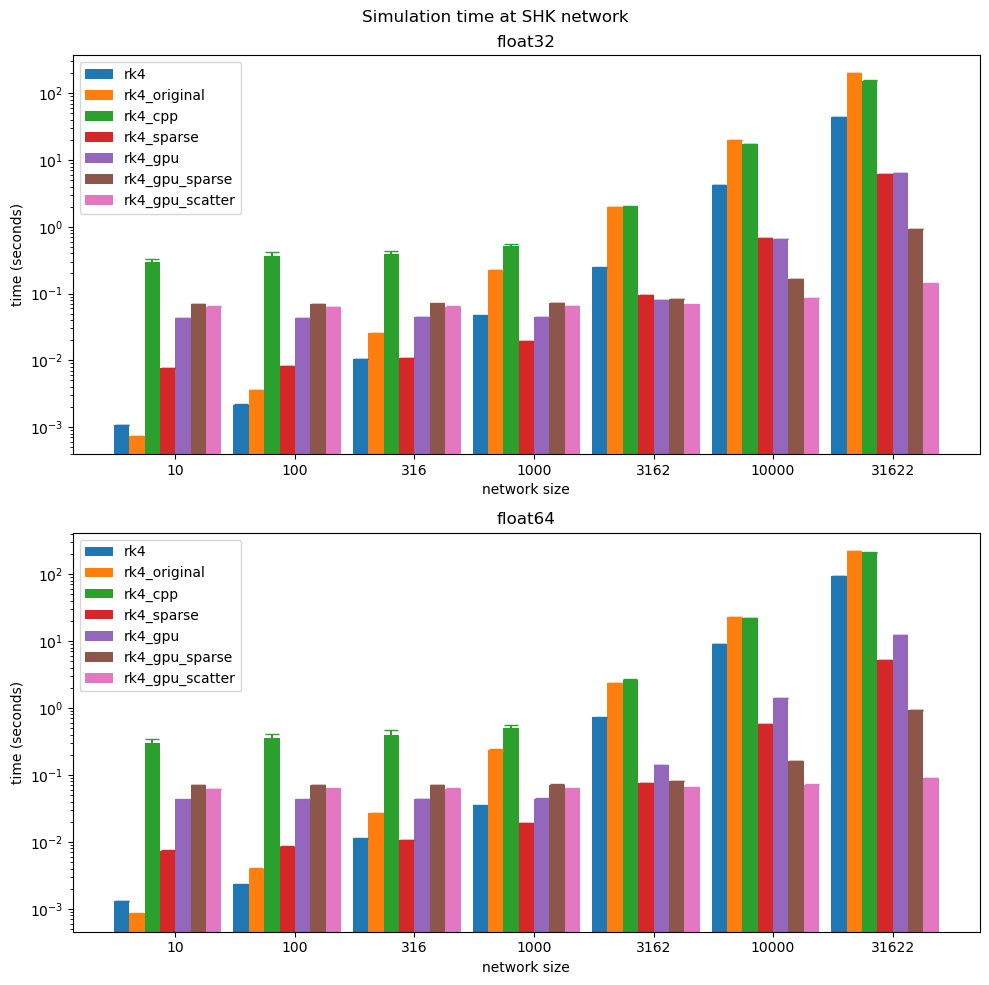

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), nrows=2)

plot_size_timeit("rk4", timeit32, ax1)
ax1.set_title("float32")
ax1.set_yscale("log")
ax1.set_xlabel("network size")
ax1.set_ylabel("time (seconds)")

plot_size_timeit("rk4", timeit64, ax2)
ax2.set_title("float64")
ax2.set_yscale("log")
ax2.set_xlabel("network size")
ax2.set_ylabel("time (seconds)")

fig.suptitle("Simulation time at SHK network")
fig.tight_layout()
fig.show()